# Neural Style Transfer
* Created for Understanding NST (Neural Style Transfer) and Creating Art with Keras & Colab. 
* Used for a coursework (717303) at Hallym Univ.

In [1]:
!pwd

/content


In [0]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(3) # gpu idx

In [3]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras import backend as K

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls

'$'   drive   out   sample_data


* 아래와 같이 'AICapstone-2019Fall'을 만들었다고 가정합니다. (Google Drive)

In [6]:
!ls drive/'My Drive'/'Colab Notebooks'/AICapstone-2019Fall/images

20180904_161416.jpg  gogh_starry.jpg   monet_400x300.jpg
20181031_181602.jpg  louvre_small.jpg


In [7]:
basedir = "/content/drive/My Drive/Colab Notebooks/AICapstone-2019Fall/"
print(basedir)

/content/drive/My Drive/Colab Notebooks/AICapstone-2019Fall/


In [0]:
outDir = basedir+'/out'

import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
    print('created...{}'.format(outDir))

#!ls "$outDir/../"

In [9]:
base_image_path = basedir+'images/20180904_161416.jpg'
style_reference_image_path = basedir+'images/monet_400x300.jpg'#gogh_starry

print(base_image_path)
print(style_reference_image_path )

/content/drive/My Drive/Colab Notebooks/AICapstone-2019Fall/images/20180904_161416.jpg
/content/drive/My Drive/Colab Notebooks/AICapstone-2019Fall/images/monet_400x300.jpg


### 설정

In [10]:
import datetime
str_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

#result_prefix = 'generated'
#result_prefix = 'pic1'
result_prefix = 'pic_'+str_time
print(result_prefix)

pic_20191007_090756


In [0]:
iterations  = 100

In [0]:
content_weight = 0.025

style_weight = 1.0
#Total Variation weight.
total_variation_weight = 1.0

### 그림 불러와서 테스트

In [13]:
img1 = load_img(base_image_path, target_size=(300,400))
print(img1.size)
img2 = load_img(style_reference_image_path, target_size=(300,400))
print(img2.size)

(400, 300)
(400, 300)


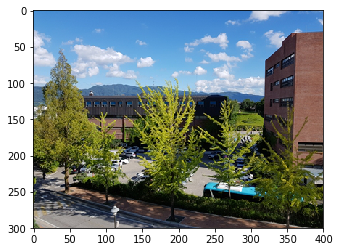

In [14]:
imgplot = plt.imshow(img1)


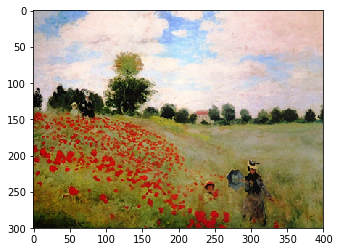

In [15]:
imgplot = plt.imshow(img2)

### The weights of the different loss components

### Dimensions of the generated picture

In [16]:
width, height = load_img(base_image_path).size
print(width, height)

400 300


In [17]:
img_nrows = 400
img_ncols = 300#int(width * img_nrows / height)
print(img_nrows, img_ncols)

400 300


### Util functions

In [0]:
#  to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [21]:
K.image_data_format()

'channels_last'

In [22]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [0]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

### build the VGG19 network

In [24]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')






Model loaded.


In [0]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

### Compute the neural style loss

In [0]:
# first we need to define 4 util functions
# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Combine these loss functions into a single scalar

In [0]:
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

In [0]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

In [0]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

In [0]:
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [34]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

In [0]:
f_outputs = K.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

In [39]:
print(outDir)

/content/drive/My Drive/Colab Notebooks/out/


In [40]:
!ls "$outDir"

pic_20191007_085341_at_iteration_0.png	 pic_20191007_085341_at_iteration_5.png
pic_20191007_085341_at_iteration_10.png  pic_20191007_085341_at_iteration_6.png
pic_20191007_085341_at_iteration_11.png  pic_20191007_085341_at_iteration_7.png
pic_20191007_085341_at_iteration_12.png  pic_20191007_085341_at_iteration_8.png
pic_20191007_085341_at_iteration_13.png  pic_20191007_085341_at_iteration_9.png
pic_20191007_085341_at_iteration_14.png  pic2_at_iteration_0.png
pic_20191007_085341_at_iteration_15.png  pic2_at_iteration_10.png
pic_20191007_085341_at_iteration_16.png  pic2_at_iteration_11.png
pic_20191007_085341_at_iteration_17.png  pic2_at_iteration_12.png
pic_20191007_085341_at_iteration_18.png  pic2_at_iteration_13.png
pic_20191007_085341_at_iteration_19.png  pic2_at_iteration_14.png
pic_20191007_085341_at_iteration_1.png	 pic2_at_iteration_15.png
pic_20191007_085341_at_iteration_20.png  pic2_at_iteration_16.png
pic_20191007_085341_at_iteration_21.png  pic2_at_iteration_17.png
pic_20191

In [41]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = outDir + '/' + result_prefix + '_at_iteration_%d.png' % i
    #fname = '/content/drive/' + result_prefix + '_at_iteration_%d.png' % i

    #!ls "/content/drive/My Drive"

    #fname = '/content/drive/My Drive/Colab Notebooks/out/'+ result_prefix + '_at_iteration_%d.png' % i
    
    print(fname)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1560207000.0
/content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_0.png
Image saved as /content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_0.png
Iteration 0 completed in 12s
Start of iteration 1
Current loss value: 835884600.0
/content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_1.png
Image saved as /content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_1.png
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 635887740.0
/content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_2.png
Image saved as /content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_2.png
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 553888200.0
/content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_3.png
Image saved as /content/drive/My Drive/Colab Notebooks/out//pic_20191

In [42]:
!ls "$outDir"

pic_20191007_085341_at_iteration_0.png
pic_20191007_085341_at_iteration_10.png
pic_20191007_085341_at_iteration_11.png
pic_20191007_085341_at_iteration_12.png
pic_20191007_085341_at_iteration_13.png
pic_20191007_085341_at_iteration_14.png
pic_20191007_085341_at_iteration_15.png
pic_20191007_085341_at_iteration_16.png
pic_20191007_085341_at_iteration_17.png
pic_20191007_085341_at_iteration_18.png
pic_20191007_085341_at_iteration_19.png
pic_20191007_085341_at_iteration_1.png
pic_20191007_085341_at_iteration_20.png
pic_20191007_085341_at_iteration_21.png
pic_20191007_085341_at_iteration_22.png
pic_20191007_085341_at_iteration_23.png
pic_20191007_085341_at_iteration_24.png
pic_20191007_085341_at_iteration_25.png
pic_20191007_085341_at_iteration_26.png
pic_20191007_085341_at_iteration_27.png
pic_20191007_085341_at_iteration_28.png
pic_20191007_085341_at_iteration_29.png
pic_20191007_085341_at_iteration_2.png
pic_20191007_085341_at_iteration_3.png
pic_20191007_085341_at_iteration_4.png
pic_2

/content/drive/My Drive/Colab Notebooks/out//pic_20191007_090756_at_iteration_99.png


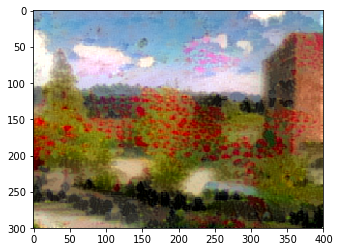

In [43]:
fnameout = outDir + '/' + result_prefix + '_at_iteration_%d.png' % (iterations-1)
imgout = load_img(fnameout, target_size=(300,400))
imgplot = plt.imshow(imgout)
print(fnameout)

### References

[1] Neural style transfer with Keras. https://keras.io/examples/neural_style_transfer/